Rewards assigned: -1 for accessible cells and -250 for obstacles
[-250   -1 -250   -1  400]
[-1 -1 -1 -1 -1]
[  -1 -250   -1   -1 -250]
[  -1   -1 -250   -1   -1]
[  -1   -1   -1   -1 -250]


Q-values at episode 0:
[ 4.601659   0.5471397 -2.2275107 -0.3915484]


Q-values at episode 50:
[289.3669  424.14084 174.51483 114.4673 ]


Q-values at episode 100:
[-37.038795   -6.9859347  -5.1883655 -12.841059 ]


Q-values at episode 150:
[ 7.661166  11.16112   -9.713007  -3.6851747]


Q-values at episode 200:
[421.3996   447.89627  101.989136  74.9697  ]




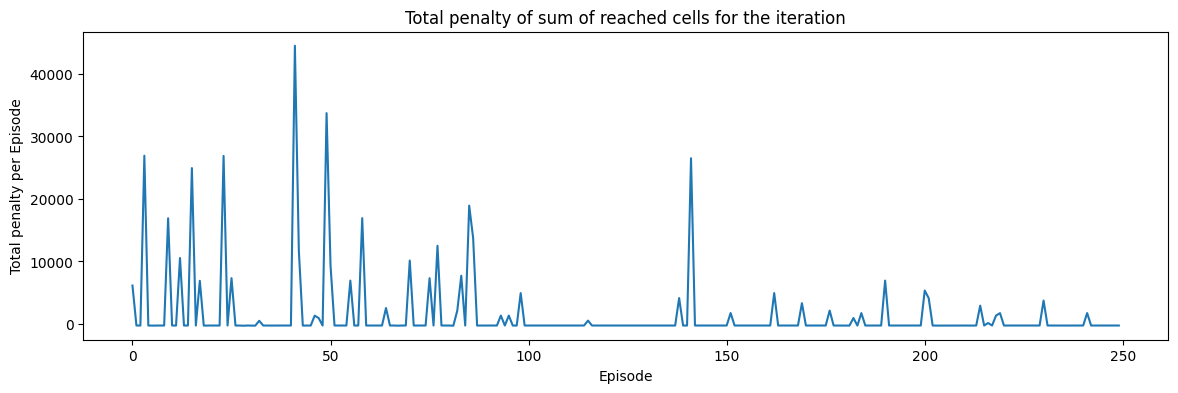

Final Q-values at episode 250:
[ -92.97505  -100.32599   -59.552345  -77.16234 ]


Steps per episode iteration:
[28, 3, 5, 107, 1, 17, 2, 1, 3, 85, 1, 7, 32, 2, 1, 80, 5, 65, 14, 1, 2, 1, 4, 136, 3, 42, 1, 6, 34, 1, 6, 24, 45, 2, 10, 8, 2, 5, 9, 4, 2, 155, 67, 9, 8, 4, 27, 13, 4, 111, 60, 1, 5, 1, 2, 34, 3, 2, 68, 4, 6, 4, 6, 1, 10, 2, 2, 25, 2, 1, 33, 3, 1, 7, 1, 50, 4, 75, 1, 1, 2, 33, 12, 58, 12, 73, 38, 6, 1, 7, 3, 2, 1, 13, 2, 12, 2, 4, 28, 1, 1, 2, 1, 4, 1, 11, 2, 2, 4, 6, 1, 10, 15, 3, 1, 16, 2, 2, 1, 1, 1, 1, 1, 5, 6, 1, 2, 3, 2, 1, 1, 1, 5, 7, 1, 1, 2, 4, 23, 4, 2, 109, 1, 2, 2, 5, 5, 2, 7, 6, 1, 10, 1, 1, 3, 2, 2, 1, 5, 2, 4, 3, 24, 1, 2, 1, 4, 1, 1, 27, 1, 1, 3, 3, 1, 2, 15, 1, 7, 3, 2, 11, 5, 9, 21, 1, 5, 6, 10, 1, 35, 1, 8, 3, 4, 1, 4, 1, 6, 1, 21, 33, 2, 14, 5, 11, 7, 6, 1, 2, 7, 3, 12, 2, 29, 1, 6, 3, 10, 26, 4, 8, 1, 1, 2, 1, 2, 2, 3, 1, 17, 1, 5, 1, 2, 2, 6, 2, 5, 4, 1, 13, 1, 3, 9, 1, 5, 5, 1, 2]


Mean squared error per episode:
[93334.234709778, 20974.177580849137, 

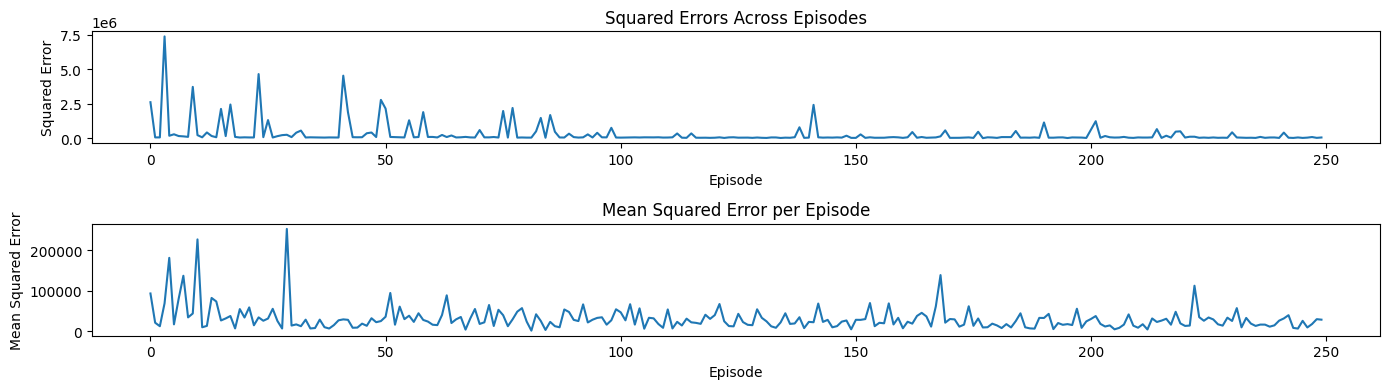

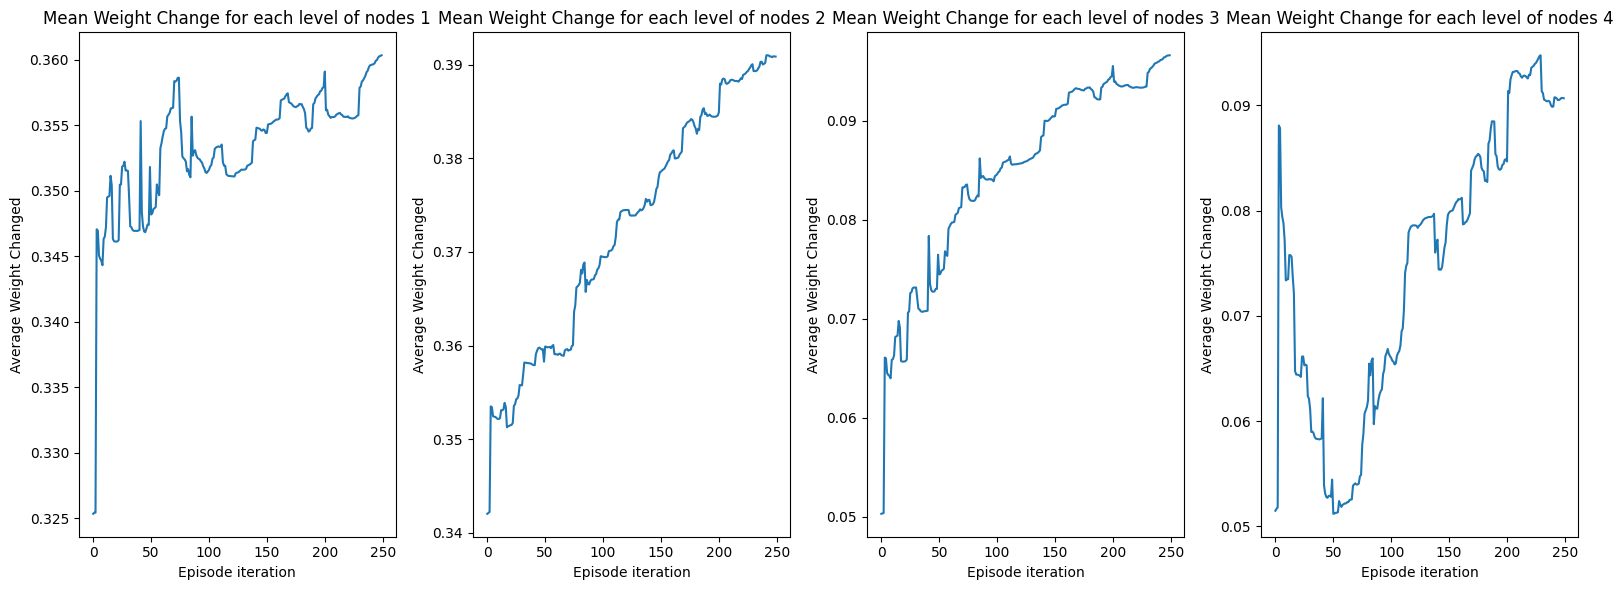

In [ ]:
# Import necessary libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Set grid dimensions to 5*5
numRows, numColumns = 5, 5

# Initialize a 3D Q-table for each state-action pair in the grid, with 4 actions (up, right, down, left)
Q_table = np.zeros((numRows, numColumns, 4))
actionsList = ['up', 'right', 'down', 'left']

# Create a rewards matrix, with -250 for obstacles
rewardMatrix = np.full((numRows, numColumns), -250)
rewardMatrix[0, 4] = 400  # Reward for reaching the target cell

# Define accessible cells in the grid
reachableCells = {
    0: [1, 3],
    1: list(range(5)),
    2: [0, 2, 3],
    3: [0, 1, 3, 4],
    4: list(range(4))
}

# Assign rewards of -1 to accessible cells to encourage optimal pathing
for row in range(5):
    for col in reachableCells[row]:
        rewardMatrix[row, col] = -1

print("Rewards assigned: -1 for accessible cells and -250 for obstacles")
for row in rewardMatrix:
    print(row)
print("\n")

# Check if a cell is an obstacle
def isObstacle(row, col):
    return rewardMatrix[row, col] == -250

# Randomly select a start position that isn't an obstacle
def getRandomStart():
    row, col = np.random.randint(numRows), np.random.randint(numColumns)
    while isObstacle(row, col):
        row, col = np.random.randint(numRows), np.random.randint(numColumns)
    return row, col

# Choose the next action using epsilon-greedy strategy
def chooseAction(row, col, epsilon):
    if np.random.random() < epsilon:
        return np.argmax(Q_table[row, col])
    else:
        return np.random.randint(4)

# Determine the next cell based on the chosen action
def nextPosition(row, col, actionIdx):
    if actionsList[actionIdx] == 'up' and row > 0:
        row -= 1
    elif actionsList[actionIdx] == 'right' and col < numColumns - 1:
        col += 1
    elif actionsList[actionIdx] == 'down' and row < numRows - 1:
        row += 1
    elif actionsList[actionIdx] == 'left' and col > 0:
        col -= 1
    return row, col

# Define the neural network for computing Q-values
class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 150)
        self.fc3 = nn.Linear(150, 100)
        self.fc4 = nn.Linear(100, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Instantiate the network and set up the optimizer
net = DeepQNetwork()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Set parameters and interval for displaying results
numEpisodes = 250
startEpsilon, minEpsilon = 0.85, 0.20
decayRate, discount, learningRate = 0.002, 0.45, 0.6
interval = 50

# Prepare lists for tracking results, including total rewards
stepsList, squaredErrorList, meanSquaredErrorList, totalRewardsList = [], [], [], []
epsilon, weightChanges = startEpsilon, [[] for _ in range(4)]

# Main Q-learning loop
for episode in range(numEpisodes):
    totalError, steps, totalReward = 0, 0, 0  # Initialize totalReward for each episode
    epsilon = max(minEpsilon, epsilon - decayRate)
    row, col = getRandomStart()

    while not isObstacle(row, col):
        state = torch.tensor([row, col], dtype=torch.float)
        actionIdx = chooseAction(row, col, epsilon)
        oldRow, oldCol = row, col
        row, col = nextPosition(row, col, actionIdx)
        reward = rewardMatrix[row, col]

        totalReward += reward  # Accumulate reward for this step

        nextState = torch.tensor([row, col], dtype=torch.float)
        nextActionIdx = chooseAction(row, col, epsilon)

        oldQ = net(state)[actionIdx]
        target = reward + discount * net(nextState)[nextActionIdx]
        loss = nn.MSELoss()(oldQ, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalError += loss.item()
        steps += 1

    # Store total rewards and errors after each episode
    stepsList.append(steps)
    squaredErrorList.append(totalError)
    meanSquaredErrorList.append(totalError / steps if steps > 0 else 0)
    totalRewardsList.append(totalReward)  # Track total rewards for each episode

    if episode % interval == 0:
        print(f"Q-values at episode {episode}:")
        print(net(state).detach().numpy())
        print("\n")

    for i in range(4):
        weightChanges[i].append(torch.mean(torch.abs(list(net.parameters())[i].data)).item())

# Plot the total reward per episode
plt.figure(figsize=(14, 4))
plt.plot(range(numEpisodes), totalRewardsList)
plt.title('Total penalty of sum of reached cells for the iteration')
plt.xlabel('Episode')
plt.ylabel('Total penalty per Episode')
plt.show()

# Display final Q-values and episode metrics
finalQ = net(state).detach().numpy()
print("Final Q-values at episode 250:")
print(finalQ)
print("\n")

print("Steps per episode iteration:")
print(stepsList)
print("\n")

print("Mean squared error per episode:")
print(meanSquaredErrorList)
print("\n")

plt.figure(figsize=(14, 4))
plt.subplot(2, 1, 1)
plt.plot(range(numEpisodes), squaredErrorList)
plt.title('Squared Errors Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Squared Error')

plt.subplot(2, 1, 2)
plt.plot(range(numEpisodes), meanSquaredErrorList)
plt.title('Mean Squared Error per Episode')
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()

# Plot weight changes for each layer over episodes
plt.figure(figsize=(16, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.plot(range(numEpisodes), weightChanges[i])
    plt.title(f'Mean Weight Change for each level of nodes {i+1}')
    plt.xlabel('Episode iteration')
    plt.ylabel('Average Weight Changed')

plt.tight_layout()
plt.show()
